# 연구를 위한 Deep Agent 설계(Deep Agent for Research)

이전까지 알아본 모든 내용을 종합하여 Deep Agent를 완성합니다.

**Context Offloading**, **Sub-agent Delegation**, **Strategic Thinking** 을 결합하여 복잡한 리서치 워크플로우를 최적화하는 방법을 다룹니다.

**🏆 핵심 내용**

*   **Deep Agent 아키텍처**: 파일 기반 컨텍스트 관리 및 토큰 효율화
*   **Search Tool**: Tavily API 연동, 웹페이지 요약, 파일 저장
*   **Think Tool**: 리서치 진행 상황 분석 및 전략적 의사결정 도구
*   **Sub-agent**: Research Sub-agent 구성 및 작업 위임

In [1]:
from dotenv import load_dotenv
from langchain_teddynote import logging

# 환경 변수 로드
load_dotenv(override=True)
# 추적을 위한 프로젝트 이름 설정
logging.langsmith("Deep-Agent-Tutorial")

LangSmith 추적을 시작합니다.
[프로젝트명]
Deep-Agent-Tutorial


## Deep Agent 아키텍처 및 도구 설계

![agent_header](./assets/agent_header.png)

**핵심 구조**

*   **TODO List**: 작업 진행 상황 관리
*   **File System**: 원본 데이터 저장 (Context Offloading)
*   **Sub-agent**: 리서치 작업 위임 및 컨텍스트 분리

## 도구(Research)

이 모듈은 리서치 에이전트를 위한 검색 및 콘텐츠 처리 유틸리티 제공.
웹 검색 기능 및 콘텐츠 요약 도구 포함.

### Search Tool 설계

웹 검색 결과를 파일로 저장하고 요약본만 에이전트에게 전달하여 토큰 효율성을 극대화합니다.

*   **`run_tavily_search`**: Tavily API 기반 웹 검색
*   **`summarize_webpage_content`**: gpt 활용 구조적 요약 및 파일명 생성
*   **`process_search_results`**: HTML → Markdown 변환 및 결과 처리
*   **`tavily_search` (Tool)**: 검색-요약-저장 통합 프로세스, 최소 정보 반환
*   **`think_tool`**: 리서치 결과 분석 및 전략적 의사결정 지원

In [2]:
from typing import Literal
from tavily import TavilyClient


tavily_client = TavilyClient()


def run_web_search(
    search_query: str,
    max_results: int = 2,
    topic: Literal["general", "news", "finance"] = "general",
    include_raw_content: bool = True,
) -> dict:
    """Perform search using Tavily API for a single query.

    Args:
        search_query: Search query to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        Search results dictionary
    """
    result = tavily_client.search(
        search_query,
        max_results=max_results,
        include_raw_content=include_raw_content,
        topic=topic,
    )
    return result

    # results = [
    #     f'<document><title>{r["title"]}</title><content>{r["content"]}</content><url>{r["url"]}</url></document>'
    #     for r in result["results"]
    # ]

    # return "\n\n".join(results)

In [3]:
result = run_web_search("테디노트 rag 에 대해서 검색해줘")
print(result)

{'query': '테디노트 rag 에 대해서 검색해줘', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.youtube.com/watch?v=wDUl7KjV7KI', 'title': '[AI 개발자가 되고 싶으세요? 저자 X 테디노트] 여섯 명의 ... - YouTube', 'content': '[AI 개발자가 되고 싶으세요? 저자 X 테디노트] 여섯 명의 개발자가 기록한 AI 시대의 생존 전략\n테디노트 TeddyNote\n48700 subscribers\n84 likes\n2371 views\n27 Nov 2025\nAI 개발자가 되고 싶지만 어디서부터 시작해야 할지 막막했던 분들을 위해, 여섯 명의 현업 개발자들이 직접 경험한 시행착오와 깨달음이 담긴 AI 시대의 생존 전략을 공유합니다.\n\n✅ 라이브에서 다룰 내용\n이 책이 AI 개발자만을 위한 책이 아니라, AI 시대를 살아가는 모든 개발자를 위한 책이 된 이유를 풀어냅니다\nAI 시대에 개발자로 살아간다는 것: 커리어 확장 전략 3가지\n- AI를 도구이자 동료처럼 활용하기: \'바이브 코딩\'을 통해 LLM을 활용한 업무 효율화와 자동화 테스트 워크플로우를 제시합니다.\n- 커리어 전환/성장의 기회 포착: 기존 백엔드/풀스택 개발자가 AI 시스템 아키텍처와 운영 안정성을 담당하며 커리어를 확장한 사례.\n- AI 기술의 본질을 이해하는 시각: 단순 튜토리얼을 넘어 연구자의 관점에서 AI 기술의 큰 그림을 파악하는 법.\n\n누군가 걸어본 길: 독자들이 당장 적용할 수 있는 실무 로드맵\n- AI에 관심은 있지만 막막한 입문자 와 AI 분야로 커리어 전환을 고민하는 현업 엔지니어 를 위한 실용적인 가이드.\n- 기술 변화 속에서 길을 찾는 모든 독자에게 작은 나침반이 될 경험 공유\n- 특징: AI와의 협업하는 시대의 상징으로 책의 모든 삽화가 챗GPT-5를 통해 생성되었습니다.\

In [4]:
result["results"][0]

{'url': 'https://www.youtube.com/watch?v=wDUl7KjV7KI',
 'title': '[AI 개발자가 되고 싶으세요? 저자 X 테디노트] 여섯 명의 ... - YouTube',
 'content': '[AI 개발자가 되고 싶으세요? 저자 X 테디노트] 여섯 명의 개발자가 기록한 AI 시대의 생존 전략\n테디노트 TeddyNote\n48700 subscribers\n84 likes\n2371 views\n27 Nov 2025\nAI 개발자가 되고 싶지만 어디서부터 시작해야 할지 막막했던 분들을 위해, 여섯 명의 현업 개발자들이 직접 경험한 시행착오와 깨달음이 담긴 AI 시대의 생존 전략을 공유합니다.\n\n✅ 라이브에서 다룰 내용\n이 책이 AI 개발자만을 위한 책이 아니라, AI 시대를 살아가는 모든 개발자를 위한 책이 된 이유를 풀어냅니다\nAI 시대에 개발자로 살아간다는 것: 커리어 확장 전략 3가지\n- AI를 도구이자 동료처럼 활용하기: \'바이브 코딩\'을 통해 LLM을 활용한 업무 효율화와 자동화 테스트 워크플로우를 제시합니다.\n- 커리어 전환/성장의 기회 포착: 기존 백엔드/풀스택 개발자가 AI 시스템 아키텍처와 운영 안정성을 담당하며 커리어를 확장한 사례.\n- AI 기술의 본질을 이해하는 시각: 단순 튜토리얼을 넘어 연구자의 관점에서 AI 기술의 큰 그림을 파악하는 법.\n\n누군가 걸어본 길: 독자들이 당장 적용할 수 있는 실무 로드맵\n- AI에 관심은 있지만 막막한 입문자 와 AI 분야로 커리어 전환을 고민하는 현업 엔지니어 를 위한 실용적인 가이드.\n- 기술 변화 속에서 길을 찾는 모든 독자에게 작은 나침반이 될 경험 공유\n- 특징: AI와의 협업하는 시대의 상징으로 책의 모든 삽화가 챗GPT-5를 통해 생성되었습니다.\n\n🙇\u200d♂️ 연사님을 소개합니다. \n최남규\n- 25년 경력의 베테랑 개발자로, 금융/공공 시스템 구축 경험을 바탕으로 AI 백엔드 시스템 아키텍트로 커리어 확장\n- L

In [5]:
from datetime import datetime


def get_current_time() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%b %-d, %Y %H:%M:%S (%A)")

In [6]:
get_current_time()

'Nov 29, 2025 16:59:03 (Saturday)'

## 웹 검색 결과 컨텍스트 최적화를 위한 요약 파이프라인

요약된 결과 형식
- `filename`: 요약된 파일명
- `summary`: 요약된 내용

In [7]:
# 요약 프롬프트
SUMMARIZE_WEB_SEARCH = """You are creating a minimal summary for research steering - your goal is to help an agent know what information it has collected, NOT to preserve all details.

<webpage_content>
{webpage_content}
</webpage_content>

Create a VERY CONCISE summary focusing on:
1. Main topic/subject in 1-2 sentences
2. Key information type (facts, tutorial, news, analysis, etc.)
3. Most significant 1-2 findings or points
4. Write the summary in Korean

Keep the summary under 150 words total. The agent needs to know what's in this file to decide if it should search for more information or use this source.

Generate a descriptive filename that indicates the content type and topic (e.g., "mcp_protocol_overview.md", "ai_safety_research_2024.md").

Output format:
```json
{{
   "filename": "descriptive_filename.md",
   "summary": "Very brief summary under 150 words focusing on main topic and key findings"
}}
```

Today's date: {date}
"""

In [8]:
from langchain_core.messages import HumanMessage, ToolMessage
from pydantic import BaseModel, Field
from langchain.chat_models import init_chat_model

# 요약을 위한 LLM 초기화
summarization_model = init_chat_model(
    model="anthropic:claude-haiku-4-5", temperature=0.0
)


class Summary(BaseModel):
    """Schema for webpage content summarization."""

    filename: str = Field(description="Name of the file to store.")
    summary: str = Field(description="Key learnings from the webpage.")


def summarize_webpage_contents(webpage_contents: list[str]) -> list[Summary]:
    """Summarize multiple webpage contents in parallel using batch processing.

    LangChain의 batch() 메서드를 활용하여 여러 웹페이지 콘텐츠를 병렬로 요약

    Args:
        webpage_contents: List of raw webpage contents to summarize

    Returns:
        List of Summary objects with filename and summary for each content
    """
    if not webpage_contents:
        return []

    # 구조화된 출력 모델 설정
    structured_model = summarization_model.with_structured_output(Summary)

    # 각 콘텐츠에 대한 메시지 리스트 생성 (batch 입력 형식)
    batch_inputs = [
        [
            HumanMessage(
                content=SUMMARIZE_WEB_SEARCH.format(
                    webpage_content=content, date=get_current_time()
                )
            )
        ]
        for content in webpage_contents
    ]

    try:
        # batch() 메서드로 병렬 처리 실행
        summaries = structured_model.batch(batch_inputs)
        return summaries

    except Exception as e:
        # 실패시 기본 요약 객체 리스트 반환
        print(f"Batch processing failed: {e}, falling back to sequential processing")
        return [
            Summary(
                filename=f"search_result_{i}.md",
                summary=(content[:1000] + "..." if len(content) > 1000 else content),
            )
            for i, content in enumerate(webpage_contents)
        ]

In [9]:
# 요약 테스트 결과(2건)
summarize_webpage_contents(result["results"])

[Summary(filename='ai_developer_career_guide_2025.md', summary='**주제**: 6명의 현업 AI 개발자가 공유하는 AI 시대 커리어 생존 전략 및 개발자 경로 가이드\n\n**콘텐츠 유형**: 라이브 세미나 기록 (저자 인터뷰, 경험 공유, Q&A)\n\n**핵심 내용**:\n- 바이브 코딩(AI 활용 개발)의 현실: 생산성 향상이지만 기본 개발 역량 필수\n- 개발자 대체 가능성: 단순 코딩은 자동화되지만 아키텍처, 커뮤니케이션, 문제 정의 능력은 여전히 중요\n- 커리어 전환 경로: 비전공자도 가능, 부트캠프 추천, 포트폴리오 중요\n- 주니어 개발자 조언: AI와 함께 학습, 운영 경험 중요, 기본기 습득 필수\n- 시니어 개발자: 기존 경험 활용하여 AI 응용 개발로 전환 가능\n\n**저자 배경**: 금융시스템 아키텍트, AI 플랫폼 리더, 게임/생성AI 연구자 등 다양한 경력'),
 Summary(filename='rag_langchain_tutorial_guide.md', summary='테디노트의 RAG 비법노트는 LangChain을 활용한 RAG(Retrieval-Augmented Generation) 시작 가이드입니다.\n\n**주요 내용:**\n- RAG 프로세스의 기본 개념부터 실무 활용까지 단계별 학습\n- PDF 기반 QA 챗봇 구축 프로젝트 (파일 업로드, 문서 청킹, 검색 등)\n- Streamlit을 이용한 UI 개발, LangSmith 디버깅 도구 활용\n- 프롬프트 최적화 및 다양한 LLM 모델 적용 방법\n\n**특징:**\n유튜브 2만 구독자 설문 기반으로 제작된 초보자 친화적 튜토리얼로, 이론과 실습 코드를 함께 제공합니다. 고급 내용은 유료 강의에서 제공됩니다.')]

In [10]:
def process_search_results(results: dict) -> list[dict]:
    """Process search results by summarizing content in parallel using batch processing.

    LangChain의 batch() 메서드를 활용하여 여러 검색 결과를 병렬로 요약합니다.
    순차 처리 대비 처리 시간을 대폭 단축할 수 있습니다.

    Args:
        results: Tavily search results dictionary

    Returns:
        List of processed results with summaries
    """
    search_results = results.get("results", [])

    if not search_results:
        return []

    # 모든 raw_content를 리스트로 추출 (batch 입력용)
    raw_contents = [result.get("raw_content", "") for result in search_results]

    # batch 방식으로 모든 콘텐츠를 병렬 요약 처리 (summarize_webpage_contents 함수 활용)
    summary_objects = summarize_webpage_contents(raw_contents)

    # 요약 결과와 원본 검색 결과를 결합하여 최종 결과 생성
    processed_results = []
    for result, summary_obj in zip(search_results, summary_objects):
        processed_results.append(
            {
                "url": result["url"],
                "title": result["title"],
                "summary": summary_obj.summary,
                "filename": summary_obj.filename,
                "raw_content": result.get("raw_content", ""),
            }
        )

    return processed_results

In [11]:
process_search_results(result)

[{'url': 'https://www.youtube.com/watch?v=wDUl7KjV7KI',
  'title': '[AI 개발자가 되고 싶으세요? 저자 X 테디노트] 여섯 명의 ... - YouTube',
  'summary': '**주제**: 6명의 현업 개발자가 공유하는 AI 시대 커리어 전환 및 생존 전략\n\n**콘텐츠 유형**: 라이브 세미나 트랜스크립트 (책 소개 및 패널 토론)\n\n**핵심 내용**:\n- AI 개발자 정의: 모델 연구자뿐 아니라 플랫폼, 백엔드, 데이터 엔지니어 등 다양한 포지션 포함\n- 바이브 코딩 시대: AI 활용으로 생산성 극대화하되, 코드 검증과 품질 관리 필수\n- 커리어 전환 경로: 비전공자도 가능하며, 부트캠프 활용 권장\n- 주니어 개발자: 학생 시절부터 AI와 협업하며 학습 필요\n- 시니어 개발자: 기존 경험(인프라, 클라우드)과 AI 결합으로 경쟁력 확보\n- 미래 전망: 연력학 컴퓨팅, 에이전트 기술 등 새로운 패러다임 등장',
  'filename': 'ai_developer_career_guide_live_2025.md',
  'raw_content': '# [AI 개발자가 되고 싶으세요? 저자 X 테디노트] 여섯 명의 개발자가 기록한 AI 시대의 생존 전략\n## 테디노트 TeddyNote\n48700 subscribers\n84 likes\n\n### Description\n2371 views\nPosted: 27 Nov 2025\nAI 개발자가 되고 싶지만 어디서부터 시작해야 할지 막막했던 분들을 위해, 여섯 명의 현업 개발자들이 직접 경험한 시행착오와 깨달음이 담긴 AI 시대의 생존 전략을 공유합니다.\n\n✅ 라이브에서 다룰 내용\n이 책이 AI 개발자만을 위한 책이 아니라, AI 시대를 살아가는 모든 개발자를 위한 책이 된 이유를 풀어냅니다\nAI 시대에 개발자로 살아간다는 것: 커리어 확장 전략 3가지\n- AI를 도구이자 동료처럼 활용하기: \'바이브 코딩\'을 통해 LLM을 활용

In [ ]:
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from typing_extensions import Annotated, Literal
from deep_agents_from_scratch.state import DeepAgentState


@tool(parse_docstring=True)
def tavily_search(
    query: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
    max_results: Annotated[int, InjectedToolArg] = 1,
    topic: Annotated[
        Literal["general", "news", "finance"], InjectedToolArg
    ] = "general",
) -> Command:
    """웹 검색을 수행하고 상세한 결과를 파일에 저장하면서 최소한의 컨텍스트만 반환합니다.

    웹 검색을 수행하고 전체 콘텐츠를 파일에 저장하여 컨텍스트 오프로딩을 수행합니다.
    에이전트가 다음 단계를 결정하는 데 도움이 되는 필수 정보만 반환합니다.

    Args:
        query: 실행할 검색 쿼리
        state: 파일 저장을 위한 주입된 에이전트 상태
        tool_call_id: 주입된 도구 호출 식별자
        max_results: 반환할 최대 결과 수 (기본값: 1)
        topic: 토픽 필터 - 'general', 'news', 또는 'finance' (기본값: 'general')

    Returns:
        전체 결과를 파일에 저장하고 최소한의 요약을 제공하는 Command
    """
    # 검색 실행
    search_results = run_web_search(
        query,
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    )

    # 결과 처리 및 요약
    processed_results = process_search_results(search_results)

    # 각 결과를 파일에 저장하고 요약 준비
    files = state.get("files", {})
    saved_files = []
    summaries = []

    for i, result in enumerate(processed_results):
        # 요약에서 AI가 생성한 파일명 사용
        filename = result["filename"]

        # 전체 상세 정보를 포함한 파일 콘텐츠 생성
        file_content = f"""# Search Result: {result['title']}

**URL:** {result['url']}
**Query:** {query}
**Date:** {get_current_time()}

## Summary
{result['summary']}

## Raw Content
{result['raw_content'] if result['raw_content'] else 'No raw content available'}
"""

        files[filename] = file_content
        saved_files.append(filename)
        summaries.append(f"- {filename}: {result['summary']}...")

    # 도구 메시지를 위한 최소한의 요약 생성 - 수집된 내용에 집중
    summary_text = f"""🔍 Found {len(processed_results)} result(s) for '{query}':

{chr(10).join(summaries)}

Files: {', '.join(saved_files)}
💡 Use read_file() to access full details when needed."""

    return Command(
        update={
            "files": files,
            "messages": [ToolMessage(summary_text, tool_call_id=tool_call_id)],
        }
    )

In [13]:
@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.

    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.

    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    - How complex is the question: Have I reached the number of search limits?

    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?

    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps

    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

## Deep Agent 구성

리서치 에이전트의 전체 구조를 조립합니다.

*   **Research Sub-agent**: `tavily_search`, `think_tool` 할당 → 정보 탐색 및 분석 집중
*   **Parent Agent**: `task`(위임), `think_tool`, 파일 시스템 도구 할당 → 전체 조율 및 관리
*   **효과**: 명확한 역할 분리를 통한 복잡한 워크플로우의 체계적 관리

In [14]:
from datetime import datetime

from IPython.display import display
from langchain.chat_models import init_chat_model
from langchain.agents import create_agent
from utils import show_prompt, stream_agent

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.prompts import (
    FILE_USAGE_INSTRUCTIONS,
    RESEARCHER_INSTRUCTIONS,
    SUBAGENT_USAGE_INSTRUCTIONS,
    TODO_USAGE_INSTRUCTIONS,
)

from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.task_tool import _create_task_tool
from deep_agents_from_scratch.todo_tools import write_todos, read_todos

# LLM 객체 초기화
model = init_chat_model(model="anthropic:claude-sonnet-4-5", temperature=0.0)

# 리서치 서브에이전트 동시 실행 최대 개수 및 반복 횟수 제한 설정
max_concurrent_research_units = 3
max_researcher_iterations = 3

# 리서치 서브에이전트에 할당할 도구 리스트 (웹 검색 및 전략적 사고 도구)
sub_agent_tools = [tavily_search, think_tool]
# 메인 에이전트에 할당할 파일 시스템 및 TODO 관리 도구, 전략적 사고 도구 포함
built_in_tools = [ls, read_file, write_file, write_todos, read_todos, think_tool]

# 리서치 서브에이전트 구성 정보 (이름, 설명, 프롬프트, 도구 목록)
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": RESEARCHER_INSTRUCTIONS.format(date=get_current_time()),
    "tools": ["tavily_search", "think_tool"],
}

# 서브에이전트에게 작업 위임을 위한 Task Tool 생성 (모델, 상태, 도구 전달)
task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

# 메인 에이전트에 위임 도구 포함 전체 도구 리스트 생성 (검색 도구 직접 사용 가능)
delegation_tools = [task_tool]
all_tools = (
    sub_agent_tools + built_in_tools + delegation_tools
)  # search available to main agent for trivial cases

# 서브에이전트 프롬프트 생성 (최대 동시 리서치 개수, 반복 횟수, 날짜 포함)
SUBAGENT_INSTRUCTIONS = SUBAGENT_USAGE_INSTRUCTIONS.format(
    max_concurrent_research_units=max_concurrent_research_units,
    max_researcher_iterations=max_researcher_iterations,
    date=datetime.now().strftime("%a %b %-d, %Y"),
)

In [15]:
# 리서처 에이전트 프롬프트 출력
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 1-2 search tool calls maximum                                                        │
│  - **Normal queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Very Complex queries**: Use up to 5 search tool calls maximum                                              │
│  - **Always stop**: After 5 search tool calls if you c

In [16]:
# TODO 관리, 파일 시스템 사용, 서브에이전트 위임 관련 프롬프트를 하나의 문자열로 통합
INSTRUCTIONS = (
    "# TODO MANAGEMENT\n"
    + TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# FILE SYSTEM USAGE\n"
    + FILE_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# SUB-AGENT DELEGATION\n"
    + SUBAGENT_INSTRUCTIONS
)

# 통합된 프롬프트를 화면에 출력하여 에이전트의 역할 및 사용법 안내
show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # TODO MANAGEMENT                                                                                              │
│  Based upon the user's request:                                                                                 │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # FILE SYSTEM USAGE                                                                                            │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Research**: Proceed with research. The search tool will write files.                                      │
│  4. **Read**: Once you are satisfied with the collected sources, read the files and use them to answer the      │
│  user's question directly.                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # SUB-AGENT DELEGATION                                                                                         │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                                                                                 │
│  <Task>                                               

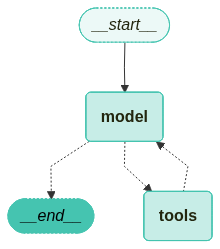

In [17]:
from langchain_teddynote.graphs import visualize_graph

# Deep Agent 생성 및 설정
agent = create_agent(
    model, all_tools, system_prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# 에이전트 시각화
visualize_graph(agent)

In [ ]:
from utils import format_messages

# 에이전트에게 MCP 개요 요청 메시지 전달 및 응답 결과 저장
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

# 에이전트 응답 메시지 포맷팅 및 출력, 사용자 친화적 결과 확인 목적
format_messages(result["messages"])

## 실행 결과 트레이스 (LangSmith)

Deep Agent의 실제 실행 흐름, 검색/요약 처리, 파일 저장 과정을 시각적으로 확인합니다.

*   [실행 트레이스 예시 보기](https://smith.langchain.com/public/3a389ec6-8e6e-4f9e-9a82-0d0a9569e6f8/r)